<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Launch New Products

Today you are a machine learning engineer at the Department of New Products at Target Cosmetics! 

We will start with a small dataset on interactions between users and current products from the past and try to discover substructure, if there's any, by applying some **unsupervised learning** methods. 

Then we will leverage the small amount of labeled data (current products) in combination with a larger amount of unlabeled data (new products to launch) to make estimations as to which products with sell more. 

## Learning Objectives

By the end of this session, you will be able to:

- apply dimensionality reduction techniques to reduce features to a lower dimensional space
- perform customer segmentation, determine optional number of clusters, and understand assumptions for used algorithm
- understand what semi-supervised learning is and leverage it to improve performance of supervised learning

## Task 1. Dimensionality Reduction

1. Load in the data. 
    
    Import `pandas` as `pd` and use `pd.read_csv()` to read in `past.csv.gz` in the `dat` folder, saving it as `past`. 
    
    Data in `past.csv.gz` was propcessed; e.g., features indicating time of day, day of week, month, and year of the purchase have been converted to one-hot representations of these categories. 

In [43]:
import pandas as pd
past = pd.read_csv("../dat/past.csv.gz", compression="gzip")

In [44]:
past.columns

Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')

<details>
<summary> Expected output </summary>

```
Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')
```
</details>

2. What percentage of the interactions (rows) resulted in a purchase?

    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?
    
    From the classification perspective, is the data balanced?

In [45]:
past["Purchased?"].mean()

0.3438

3. Drop `product_id` and `user_id` and save the rest columns to a new `pd.DataFrame`:`X`; then pop the column `'Purchased?'` and save it to `y`.

In [46]:
# Drop the colums product_id and user_id and assign to X, create y popping the Purchased? column
X = past.drop(["product_id", "user_id"], axis=1)
y = X.pop("Purchased?")

In [47]:
assert X.shape == (5000, 34)
assert y.shape == (5000,)

4. Apply [PCA (check documentation if unfamiliar)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the number of features down to **5**, save it to an numpy array named `X_reduced`. 

    Do you need to preprocess the data before performing PCA? Quick review [here: Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).
    
    If time permits, read [Does mean centering or feature scaling affect a Principal Component Analysis?](https://sebastianraschka.com/faq/docs/pca-scaling.html) or [discussion 1](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_scaled = StandardScaler().fit_transform(X)
X_reduced = pca.fit_transform(X_scaled)

In [49]:
assert X_reduced.shape == (5000, 5)

5. Print out the percentage of variance explained by each of the selected components.

[0.10282263 0.09445822 0.06515566 0.05106176 0.04298897]
0.35648724839700197


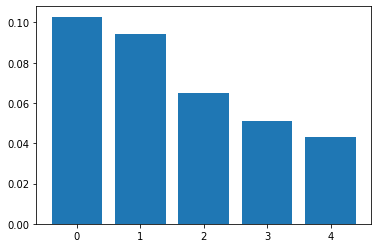

In [50]:
# Bar chart of the percentage of variance explained by each of the selected components.
# Capture the variance
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
# 35% of the variance is explained using the firsts 5 component
# where the first component explains 10% of the variance
# Plot a bar chart of the variance
import matplotlib.pyplot as plt
plt.bar(range(5), pca.explained_variance_ratio_)
plt.show()

6. Review code in functions `visualize_2pcs` and `visualize_3pcs` below and visualize first few principal components in 2D and 3D plots, respectively:

In [51]:
import matplotlib.pyplot as plt

def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

In [52]:
def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

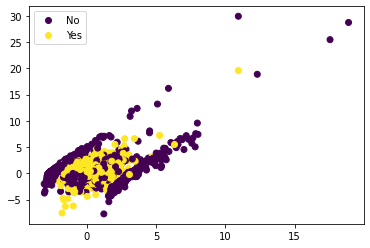

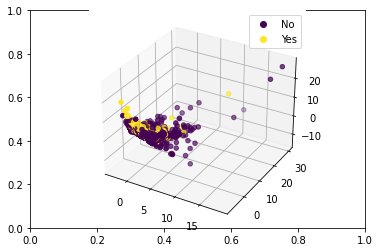

In [53]:
visualize_2pcs(X_reduced, y)
visualize_3pcs(X_reduced, y)


7. One way to assess the quality of the dimensionality reduction, when the groundtruth is available of course, is comparing the prediction performance using given features vs reduced (engineered) features.

    Complete the wrapper function below that 

    - takes features, target, and a boolean parameter indicating whether to include standardization in the pipeline or not
    - split the data into train (80%) and test (20%) datasets, set the random state for spliting at 0
    - build a pipeline that 

        1) preprocessing data using standardization if the `standardize` is `True`; otherwise skip this step  

        2) apply logistic regression ( do you consider data is balanced? )
        
    - fit the pipeline using training data
    - print the classification report (use `sklearn.metrics.classification_report`) on test data

In [54]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


def train(X, y, standardize = True) -> None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)    
    
    steps = []
    if standardize:
        steps.append(('standardize', StandardScaler()))
    steps.append(('logreg', LogisticRegression()))
    pipeline = Pipeline(steps)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))

Now apply the pipeline on the all the features `X` and review the performance

In [55]:
pipeline = train(X, y, standardize=True)

              precision    recall  f1-score   support

           0       0.66      0.93      0.77       649
           1       0.45      0.11      0.17       351

    accuracy                           0.64      1000
   macro avg       0.55      0.52      0.47      1000
weighted avg       0.58      0.64      0.56      1000



Similarly, apply the pipeline on the reduced / engineered features `X_reduced`. Should you include standardization in the pipeline?

In [56]:
pipeline = train(X_reduced, y, standardize=False)

              precision    recall  f1-score   support

           0       0.64      0.96      0.77       649
           1       0.04      0.00      0.01       351

    accuracy                           0.62      1000
   macro avg       0.34      0.48      0.39      1000
weighted avg       0.43      0.62      0.50      1000



8. Are the results as expected? Discuss the pros and cons using reduced set of features in this application with your teammate. 
given that the PCA just give five features that represent the 35% of the variance in the original dataset, It was expected to loss information.

## Task 2. Customer Segmentation

In this task, we apply k-means clustering on the reduced data, experimenting different vaules of `n_cluster`, summarize all this information in a single plot, the *Elbow* plot. In addition, leverage silhouette visualization to help decide the "optimal" number of clusters in our data and answer: 

1. Are there any patterns among customer purchasing behaviors?
2. If so, what categories do they belong to? How do you characterize the clusters?
3. If not, what followup steps and / or recommendations will you make as an MLE?

1. Look up the [documentation](https://scikit-learn.org/stable/modules/clustering.html) and import the model class for k-means from `sklearn.cluster`

In [57]:
from sklearn.cluster import KMeans

2. Complete `visualize_elbow`; inspect the code and complete

    - fit k-means on the given data `X` and `k`, setting `random_state` to be 10 for reproducibility
    - append the sum of squared distances of samples to their closest cluster center for each $k$ to list `inertias`

In [58]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        inertias.append(kmeans.inertia_)
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

3. Visualize the elbow plot for the number of clusters ranging between 2 and 9. Discuss with your teammate, what is the 'optimal' number of clusters?

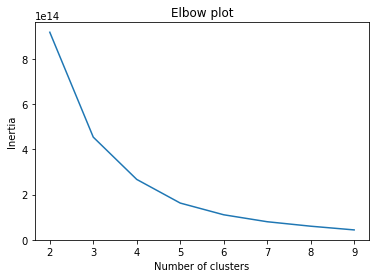

In [59]:
visualize_elbow(X, range(2,10)) # K could be 5

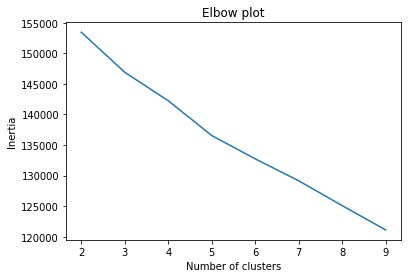

In [60]:
visualize_elbow(X_scaled, range(2,10)) # K could be 5

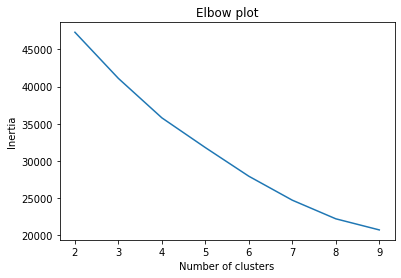

In [61]:
visualize_elbow(X_reduced, range(2,10)) # K could be 5

4. What are the disadvantage to use the Elbow method? 

Disadvantage:
1. Is time consumming if we want more tha 10 clusters
2. The elbow plot is subjective to interpretation, and the optimal number of clusters is not always the same as the number of clusters in the plot.

5. Let's try a different approach: [silhouette score](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6).

    A helper function `visualize_silhouette` is provided for you (inspect the code in `utils.py`) and figure out how to use it to visualize k-means for k ranges from 2 to 8 on the reduced data. 

In [62]:
from utils import visualize_silhouette

For n_clusters = 2 The average silhouette_score is : 0.2499838055666165
For n_clusters = 3 The average silhouette_score is : 0.25787134349505714
For n_clusters = 4 The average silhouette_score is : 0.2712778276366053
For n_clusters = 5 The average silhouette_score is : 0.30043713341270467
For n_clusters = 6 The average silhouette_score is : 0.24185301541864687
For n_clusters = 7 The average silhouette_score is : 0.24704775681453894
For n_clusters = 8 The average silhouette_score is : 0.2668264592183159


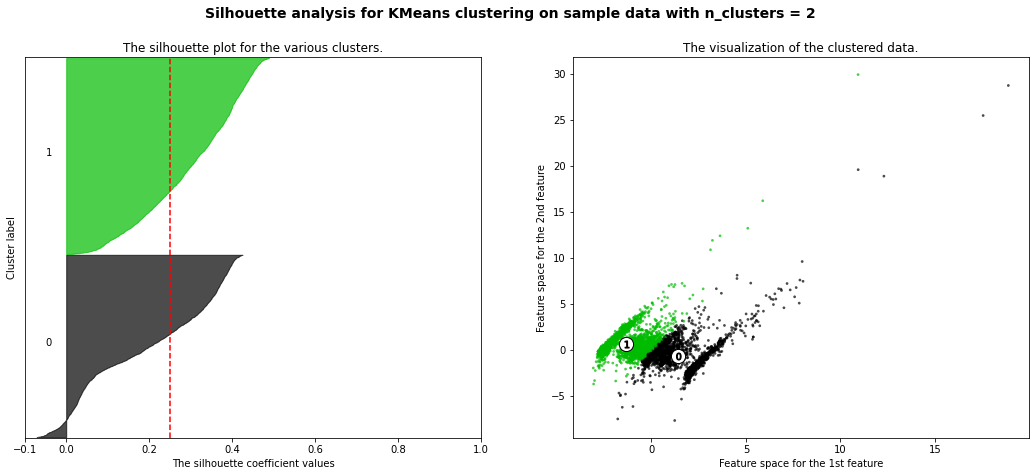

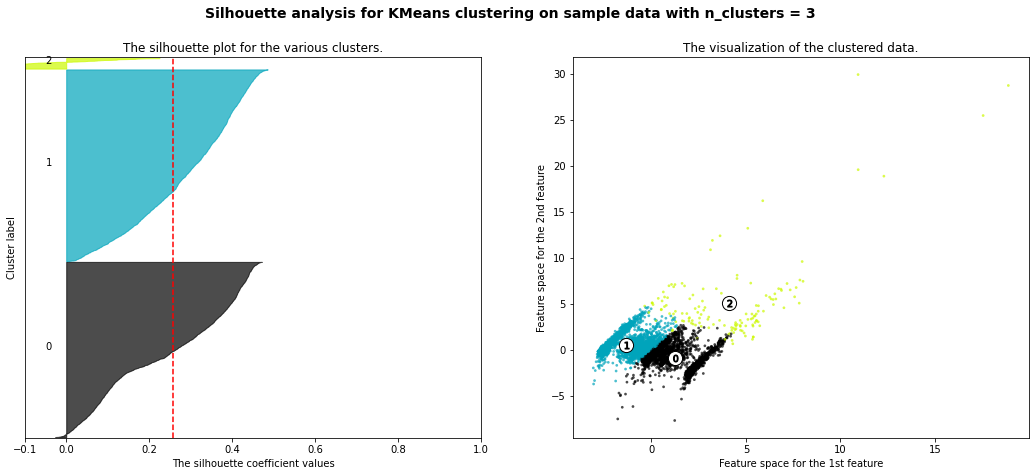

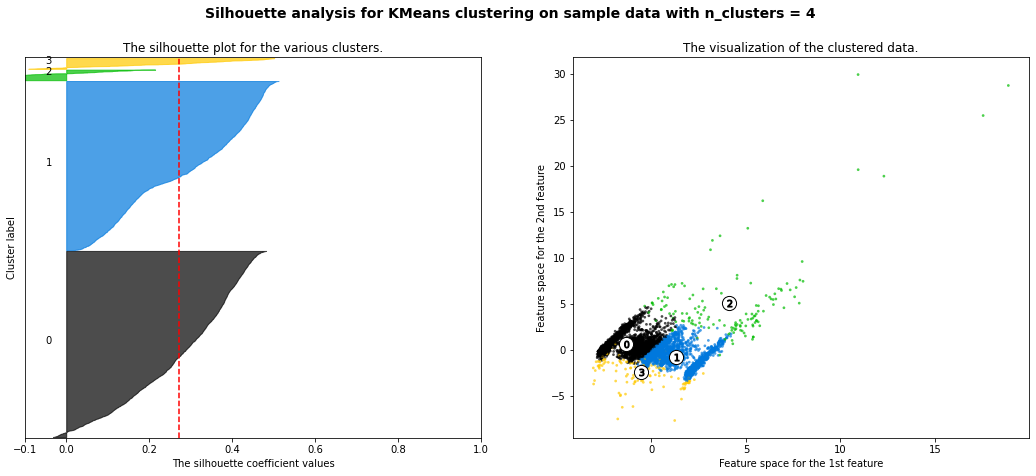

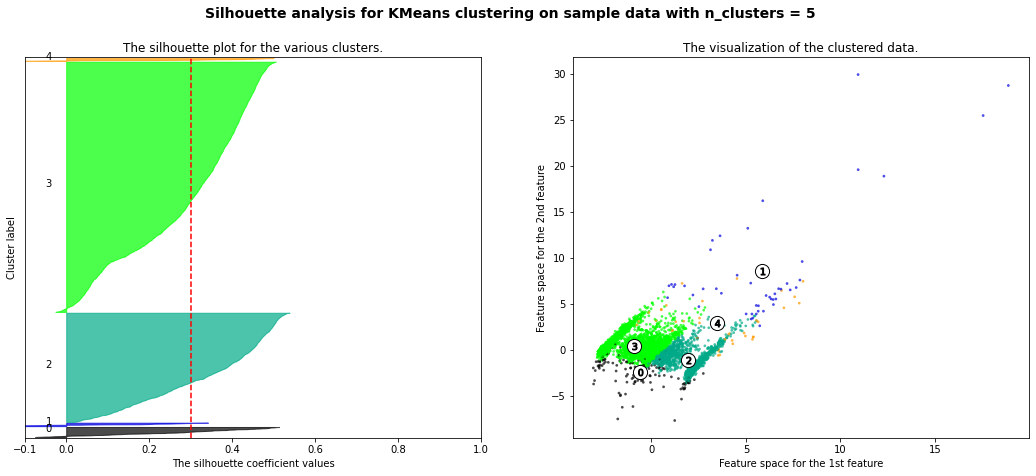

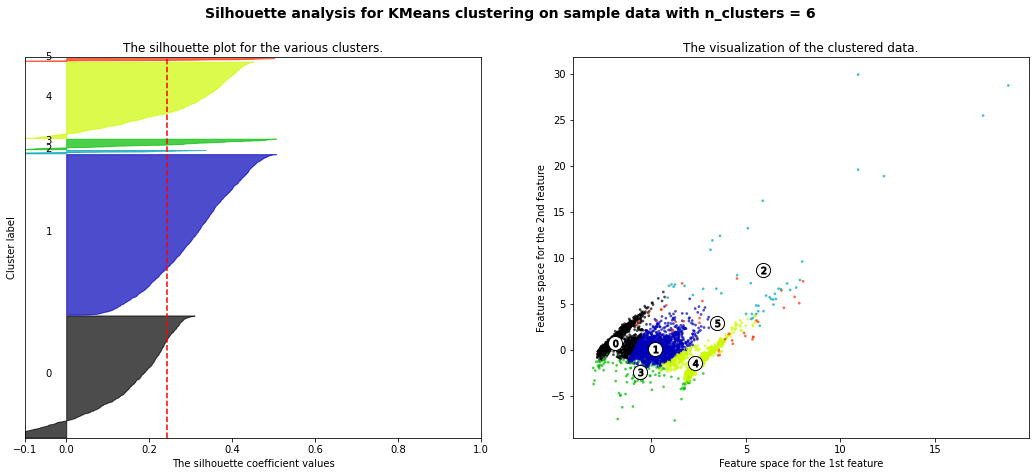

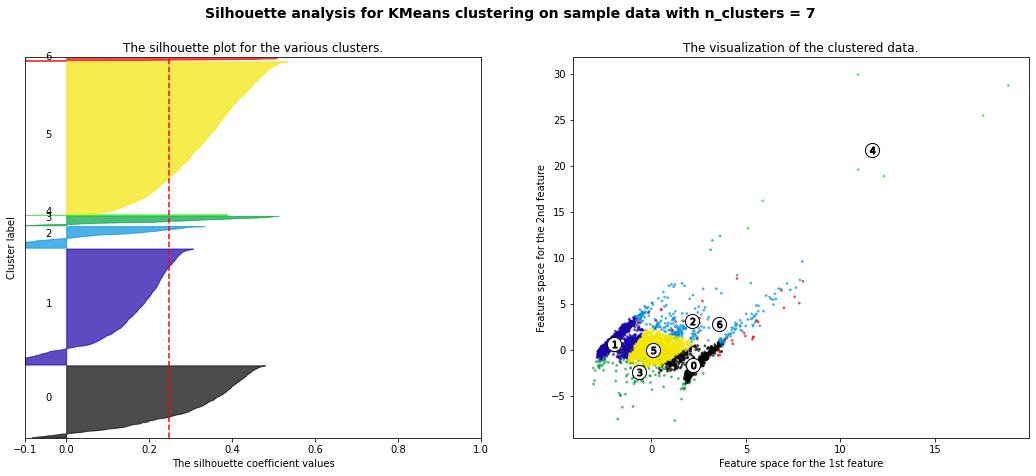

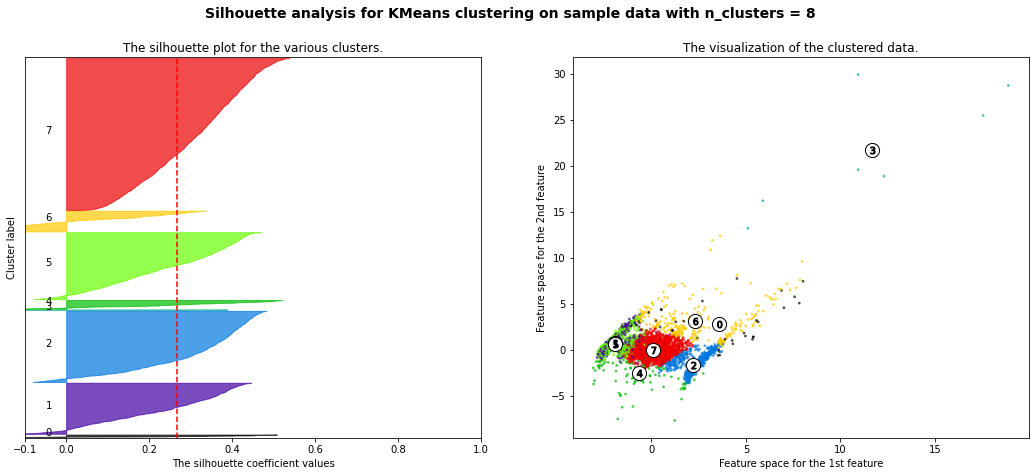

In [63]:
visualize_silhouette(8,X_reduced)

6. Instantiate a k-mean model using the number of cluster that you deem optimal, assign it to `km`, and fit on the reduced data. 

In [64]:
cluster_model = KMeans(n_clusters=4, random_state=10)
cluster_num = cluster_model.fit_predict(X_reduced)

7. What is the size of each cluster? 

In [65]:
pd.DataFrame({"cluster_id":cluster_num}).value_counts().sort_index()

cluster_id
0             2471
1             2245
2              141
3              143
dtype: int64

8. Create a new column called `cluster_pca` in `past`, with values as predicted cluster index predicted by `km`. 

In [66]:
past["cluster_pca"] = cluster_num

9. Open ended: manipulate `past` and see if you can characterize each cluster (e.g., calculate statistics of / visualize features for each cluster), how will you intepret the results? 

    **Note**. This is probably the most important part as far as the business stakeholders are concerned: "*What can I do with your results?*" The math, modeling part is relatively easy, compared to actionable recommendations you make for business. Thus, before jumping on a different algorithm for the given task, do you best to 1) understand the data in depth 2) keep buisiness use cases in mind throughout all steps. 

In [67]:
from sklearn.preprocessing import StandardScaler

In [68]:
past_scaled = StandardScaler(copy=True).fit_transform(past.drop(["product_id","user_id","cluster_pca"],axis=1))
past_scaled = pd.DataFrame(past_scaled)
past_scaled.columns = past.drop(["product_id","user_id","cluster_pca"],axis=1).columns
past_scaled["cluster_pca"] = past["cluster_pca"]
patterns = past_scaled.groupby("cluster_pca").agg(["mean","std"])

The average of all the dataset will be use as reference for the Segment of customer. for instance, if it is mention that the customer belong to the Cluster 0, and has 2 times mores number of removes than the average. this mean that is comparing the mean of the custer with the mean of the global average ( normalization)

In [89]:
past.drop(["product_id","user_id","cluster_pca"],axis=1).agg(["mean"]).T

,mean
NumOfEventsInJourney,1.951080
NumSessions,1.327052
interactionTime,249023.399113
maxPrice,7.457600
minPrice,7.426321
NumCart,0.541953
NumView,0.893687
NumRemove,0.413592
InsessionCart,23.010176
InsessionView,15.517297


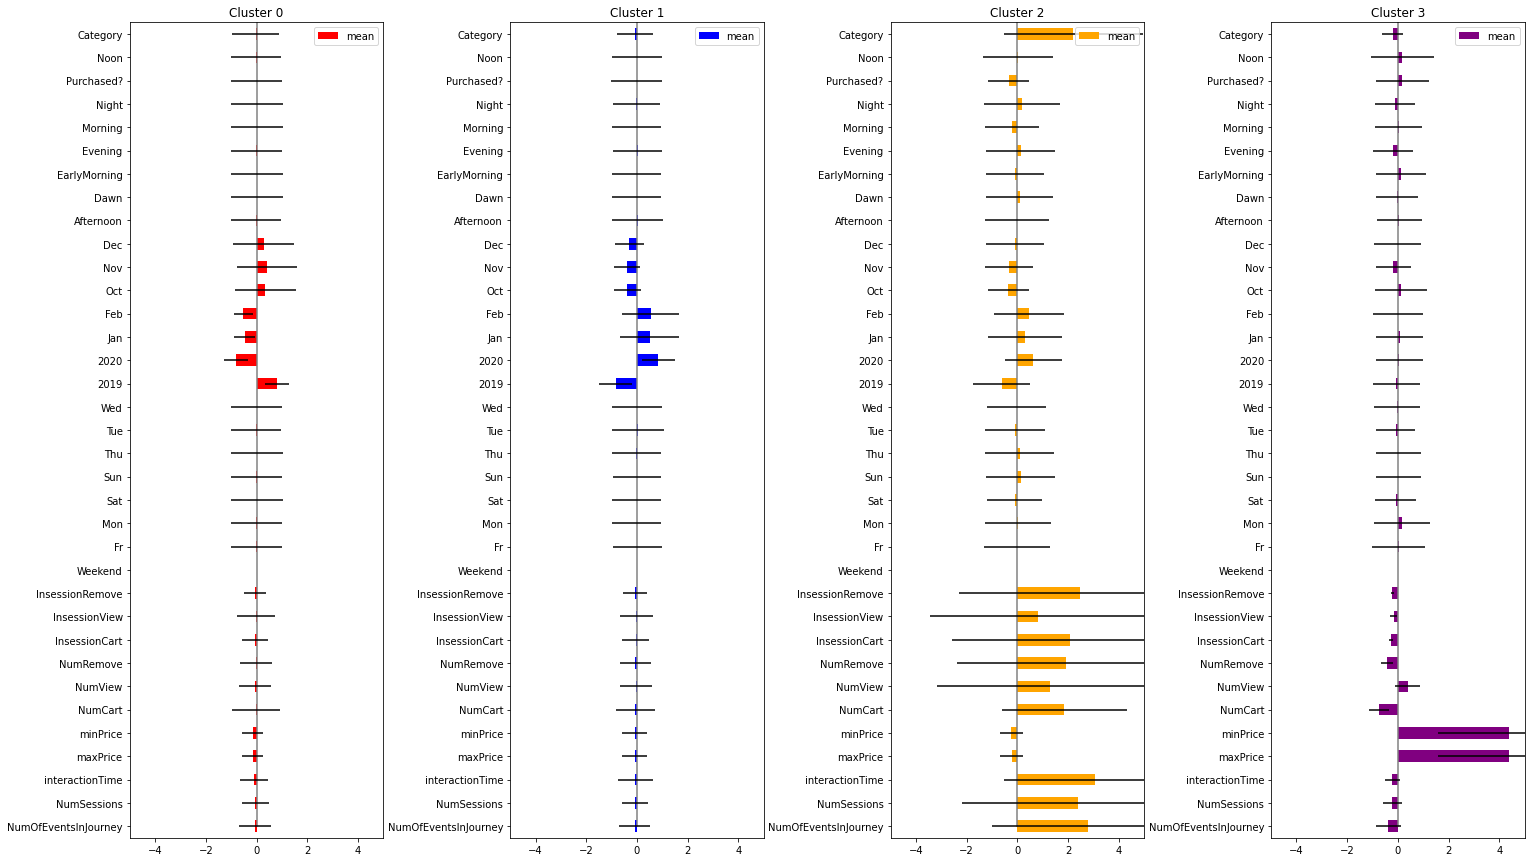

In [90]:
#drop column index
plt.figure(figsize=(25,15))
# set 4 colors for the 4 clusters, using variation of red, blue, orange and purple
colors = ["#FF0000", "#0000FF", "#FFA500", "#800080"]
for idx in range(4):
    ax = plt.subplot(1, 4, idx + 1)
    ax.set_title("Cluster %d" % idx)
    # set min and max to x-axis
    plt.xlim(-5,5)
    plt.subplots_adjust(wspace=0.5)
    # draw a line in 0 value  x-axis
    plt.plot([0,0],[0,40],color="gray")
    patterns.T.loc[:,idx].unstack().plot.barh(xerr="std",ax=ax, color=colors[idx])
plt.show()

##### Segments

All the cluster has some variables that behaves like the global average. for example, all the cluster has the same behavior related to the weekday in a sligthly same behavior in the day of purchased. Cluster 0 and 1 has similar behavior, and Cluster 2 and 3 has some variation from the mean. Considering then the behaviors that has high diferentiation from the global average, we can say that the customer segments are:

* Cluster 0: Decline App Transactors - late year Winback Strategy: Considering the variable of the years 2019 and 2020, it shows behavior of having a smaller ratio of transactions between years and it normally has higher transaction and lower transaction than the average. this segment transact more that the average on the months of Oct-Nov-Dec.

* Cluster 1: Rising App Transactors - early year momentum Strategy : in contrast with Cluster 0 , cluster 1 has a rising transaction rate in a yearly base and like to transacc more in early months.

* Cluster 2: Window Shopper - Funnel Push Strategy: this customer like to look more that the average and use more the shopping cart without doing purchased (less that the average rate). it has some similar behavior with Rising App Transacctor. 

* Cluster 3: Go to / High Value Buyer - Reward/Fidelity Strategy: Customer that buy without doubt and to any prices (on average buy at higher prices than the avergae).


10. What are the assumptions for k-means? Judging by the cluster sizes, is k-means a good approach? 

    Scanning the list of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) implemented in scikit-learn, try at least one other algorithm, examine its assumptions, and intepret results.

kmeans assumes that the data is normally distributed. meaning that Assume then that the variance is spherical and that every point belongs to a cluster.
And that the data is distributed in a dense space. meaning that the data is not sparse. This can be a good approach but with high noise given the standar deviation that we can notice in the cluster. with a algo like dbscan that is a base dense cluster it can detect cluster with less variation (noise) but at the cost of some patter not recognized. 

In [124]:
from sklearn.cluster import DBSCAN 
additional_model = DBSCAN(eps=0.65, min_samples=50)
additional_cluster_num = additional_model.fit_predict(X_reduced)

               0     1    2    3   4
cluster_id    -1     0    1    2   3
0           3262  1239  178  241  80


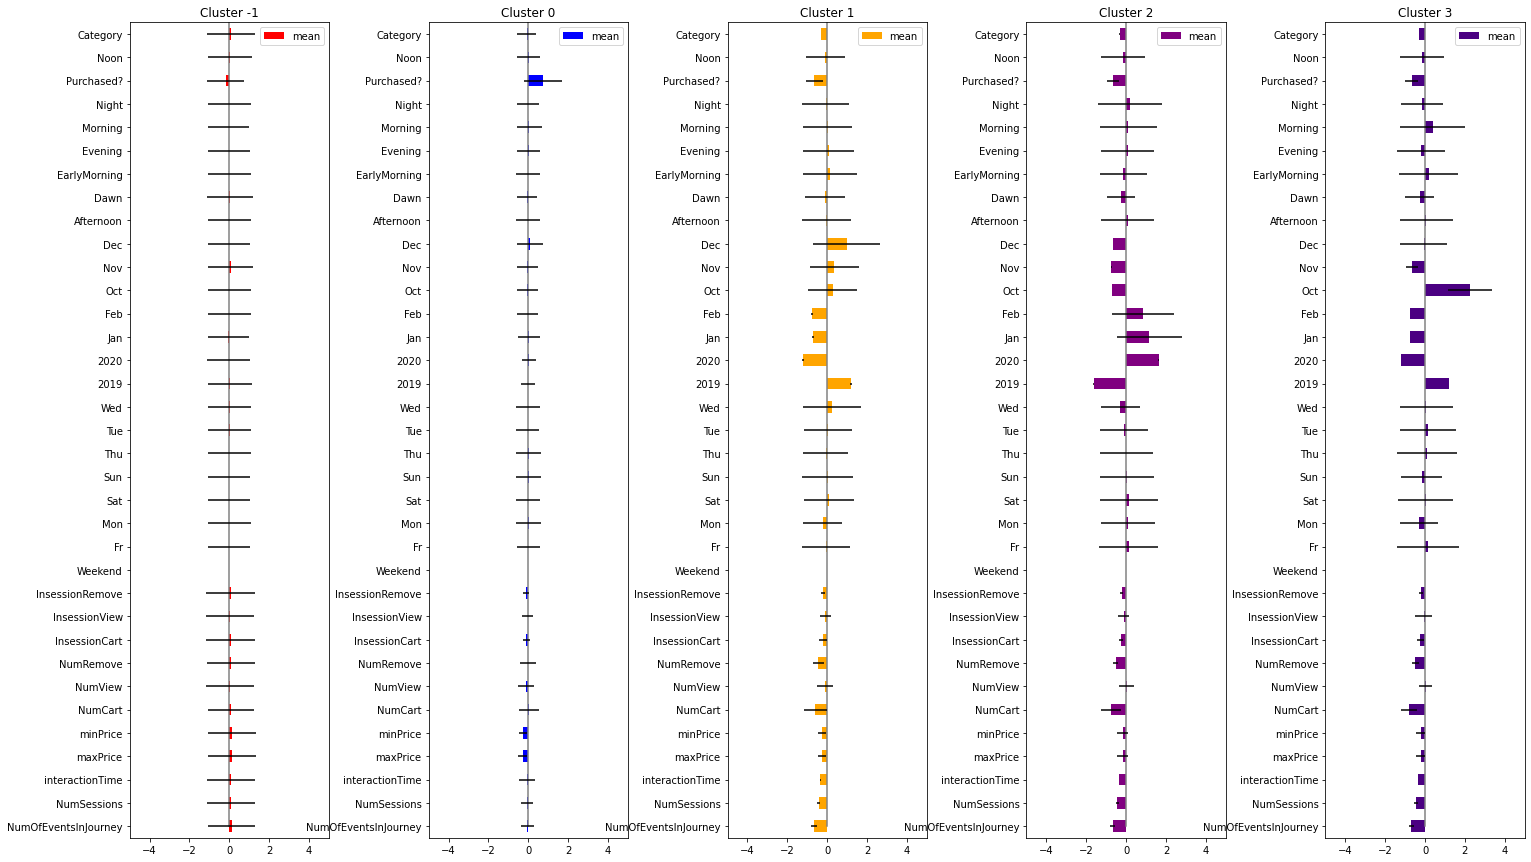

In [148]:
print(pd.DataFrame({"cluster_id":additional_cluster_num}).value_counts().sort_index().reset_index().T)
past["cluster_pca"] = additional_cluster_num
past_scaled = StandardScaler(copy=True).fit_transform(past.drop(["product_id","user_id","cluster_pca"],axis=1))
past_scaled = pd.DataFrame(past_scaled)
past_scaled.columns = past.drop(["product_id","user_id","cluster_pca"],axis=1).columns
past_scaled["cluster_pca"] = past["cluster_pca"]
patterns = past_scaled.groupby("cluster_pca").agg(["mean","std"])
#drop column index
plt.figure(figsize=(25,15))
# set 4 colors for the 5 clusters, using variation of red, blue, orange and purple
colors = ["#FF0000", "#0000FF", "#FFA500", "#800080", "#4B0082"]
names = patterns.T.columns.to_list()
for idx in range(5):
    ax = plt.subplot(1, 5, idx + 1)
    ax.set_title("Cluster %d" % names[idx])
    # set min and max to x-axis
    plt.xlim(-5,5)
    plt.subplots_adjust(wspace=0.5)
    # draw a line in 0 value  x-axis
    plt.plot([0,0],[0,40],color="gray")
    patterns.T.iloc[:,idx].unstack().plot.barh(xerr="std",ax=ax, color=colors[idx])

plt.show()

11. Jot down recommendations or followup steps, detailing the reasons.

For every cluster it should be applied the strategy associated with it and if necesary try to use a DBSCAN process in order to detect more granular segment. also given the cluster it can be applied a bucketing technique (split the data by segment) and applied a logistic regresion or classification method in order to predict the purchase behavior of the customer. and try to find more critical mass of customer in the cluster.

## Task 3. To launch or not to launch?

In this task, we will work on a hypothetical application: cosmetics purchase prediction for new products with limited features. The intention here is to maximize **recall** so that no popular cosmetic is understocked. Overstocking is less of a concern since it will not cause disengagement in customers.

The purchase status for each "new" product is known, but we only use the labels for benchmarking purpose. Instead, we use label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data. 

1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.

    Look at the shape of `new` and inspect the frist few rows.

In [151]:
#1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.
#    Look at the shape of `new` and inspect the frist few rows.
new = pd.read_csv("../dat/new.csv.gz", compression="gzip")

In [152]:
assert new.shape == (30091, 5)

In [153]:
new.head()

,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


2. How does the number of data points in the training set (`past`) compare to the number of datapoints in the test set (`new`)? 

    And how does the feature set in the training set compare to the feature set in the test set?

The new dataset has more data points than the past dataset. The feature set is smaller than the past dataset.

    *The number of datapoints in the training set is relatively small while the test set is quite large. The training set has more features than in the test set.*

3. Are there any product ids in both the training and test datasets? Hint: use `np.intersect1d` or set operations.

In [156]:
# np.intersect1d between new.product_id and past.product_id
import numpy as np
np.intersect1d(new.product_id.values, past.product_id.values)

array([], dtype=int64)

4. What percentage of data points resulted in a purchase in the test set?

    In reality, we won't be able to calculate information that is not available to you. Here, we simply demonstrated that the distributions in target between `past` and `new` are similar. 

In [157]:
# YOUR CODE HERE # ~.344
new["Purchased?"].mean()

0.3442557575354757

In [158]:
# YOUR CODE HERE # ~.344
past["Purchased?"].mean()

0.3438

5. Create `ndarray`s: `X_train`, `y_train`, `X_test`, and `y_test` according to the following guidelines.

    - The `Purchased?` column is the target.
    - `X_train` and `X_test` should contain the same features
    - `product_id` should not be a feature.

    Double check that the shapes of the four arrays are what you expect.

In [179]:
features_target = new.drop(["product_id"],axis=1).columns
target = "Purchased?"

training_df = past[features_target]
test_df = new[features_target]


In [180]:
X_train = training_df.drop(target,axis=1).to_numpy()
X_test = test_df.drop(target,axis=1).to_numpy()

In [181]:
y_train = training_df[target].to_numpy()
y_test = test_df[target].to_numpy()

In [182]:
assert X_train.shape[0] == y_train.shape[0] # 5000
assert X_train.shape[1] == X_test.shape[1]  # 3

assert type(X_train) == np.ndarray # make sure you import numpy as np at this point
assert type(X_train).__module__ == type(y_train).__module__ == np.__name__  # alternative way

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

In [183]:
# Logistic Regression over X_train and y_train
model = LogisticRegression()
scaler = StandardScaler()
scaler.fit(X_train)
model.fit(scaler.transform(X_train), y_train)
# Classification over X_test and y_test
predictions = model.predict(scaler.transform(X_test))
# Compute the accuracy of the model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.66      0.96      0.78     19732
           1       0.43      0.06      0.11     10359

    accuracy                           0.65     30091
   macro avg       0.54      0.51      0.45     30091
weighted avg       0.58      0.65      0.55     30091



7. Re-assemble data for semi-supervised learning. 
    - Use the features from the test set along with the features from the training set. 
    - Only use the labels from the training set but none from the test set.  
    
    Since we're using a large number of sampled features, but only a small number of these samples have labels, this is **semi-supervised learning**.

Create a matrix `X` that has the rows from `X_train` concatenated with the rows from `X_test`. Check the shape of the matrix.

In [184]:
# Concatenate X_train and X_test
X = np.concatenate((X_train, X_test), axis=0) 

In [185]:
assert X.shape == (35091, 3)

Create the target array `y` by concatenating `y_train` with a vector of -1's, effectively creating a dummy label for the `X_test` rows in `X`. Check the shape of the array. It should have as many values as `X` has rows.

In [192]:
# Concatenate y_train and -1*x_test
y = np.concatenate((y_train,np.array([-1]*len(X_test))), axis=0)

In [193]:
assert X.shape[0] == y.shape[0]

8. Semi-supervised learning. 

    Scikit-learn provides two label propagation models: [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) and [`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html). Both work by constructing a similarity graph over all items in the input dataset. `LabelSpreading` is similar to the basic Label Propagation algorithm, but it uses an affinity matrix based on the normalized graph Laplacian and soft clamping across the labels; thus more robust to noise. We will be using scikit-learn's `LabelSpreading` model with `kNN`.
    
    Train a `LabelSpreading` model. Set `kernel` to `knn` and `alpha` to 0.01.

In [199]:
from sklearn.semi_supervised import LabelSpreading
labeler = LabelSpreading(kernel='knn', alpha=0.01)
labeler.fit(X,y)

LabelSpreading(alpha=0.01, kernel='knn')

9. Extract the predictions for the test data. 

    You can get the predictions from the `transduction_` attribute. Note that there is a value for every row in `X`, so select just the values that correspond to `X_test`.

In [204]:
semi_sup_preds = labeler.transduction_[y==-1]

In [205]:
assert semi_sup_preds.shape[0] == X_test.shape[0]

10. Print the classification report

In [206]:
print(classification_report(y_test, semi_sup_preds)) # make sure you properly import classification_report

              precision    recall  f1-score   support

           0       0.83      0.92      0.87     19732
           1       0.81      0.63      0.71     10359

    accuracy                           0.82     30091
   macro avg       0.82      0.78      0.79     30091
weighted avg       0.82      0.82      0.82     30091



Let's bring the performance from the supervised learning model down to see the comparison; discuss the areas of improvement and reasons for improvement.

In [208]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.66      0.96      0.78     19732
           1       0.43      0.06      0.11     10359

    accuracy                           0.65     30091
   macro avg       0.54      0.51      0.45     30091
weighted avg       0.58      0.65      0.55     30091



The model needs to improve over the recall given that using the reduced datasets bring to a bad performance. and it can be that the dataset use is does not have enough data variability in order to cath all the factors. thats why a approach using semi-supervised learning is a good choice.

11. Read [Small Data Can Play a Big Role in AI](https://hbr.org/2020/02/small-data-can-play-a-big-role-in-ai) and discuss with your teammate about AI tools for training AI with small data and their use cases. 

## Acknowledgement & References

- data was adapted from Kaggle: [eCommerce Events History in Cosmetics Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)
- function `visualize_silhouette` was adapted from [plot_kmeans_silhouette_analysis by scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Categorizing Online Shopping Behavior from Cosmetics to Electronics: An Analytical Framework](https://arxiv.org/pdf/2010.02503.pdf)
- [OPAM: Online Purchasing-behavior Analysis using Machine learning](https://arxiv.org/pdf/2102.01625.pdf)